In [1]:
using Distributions
using LinearAlgebra
using Plots
using Test
using Sobol
using Optim
using Random

In [2]:
include("rollout.jl")
include("testfns.jl")
include("utils.jl")

centered_fd (generic function with 1 method)

In [3]:
# Global parameters
BATCH_SIZE = 20
HORIZON = 0
MC_SAMPLES = 50 + HORIZON*50
BUDGET = 5;

In [4]:
# Setup toy problem
testfn = TestRosenbrock()
testfn.bounds[:, 1] = [-2 -1]
testfn.bounds[:, 2] = [2 3]
lbs, ubs = testfn.bounds[:,1], testfn.bounds[:,2]

# Setup low discrepancy random number stream
lds_rns = gen_low_discrepancy_sequence(MC_SAMPLES, testfn.dim, HORIZON+1);
rns = randn(MC_SAMPLES, testfn.dim+1, HORIZON+1);

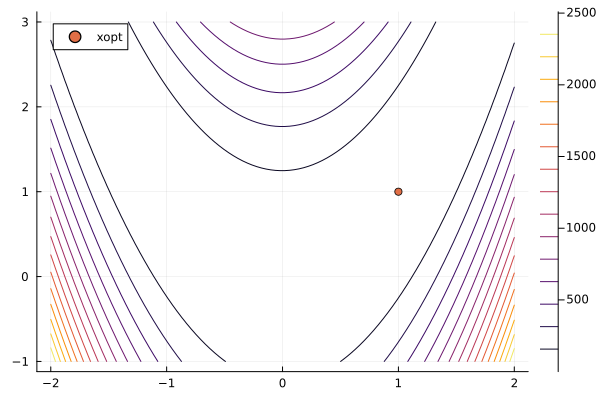

In [5]:
tplot(testfn)

In [39]:
# Gather initial samples/experimental data
N, θ = 1, [1.]
X = [-1.5 -.5; -1.5 2.5; 1.5 -.5; 1.5 2.5]'
X = Matrix(reshape(X, testfn.dim, size(X, 2)))
ψ = kernel_matern52(θ)
sur = fit_surrogate(ψ, X, testfn.f)
θ, sur = optimize_hypers(ψ.θ, kernel_matern52, sur.X, testfn.f);

### Visualize the Contours of the Underlying Objective

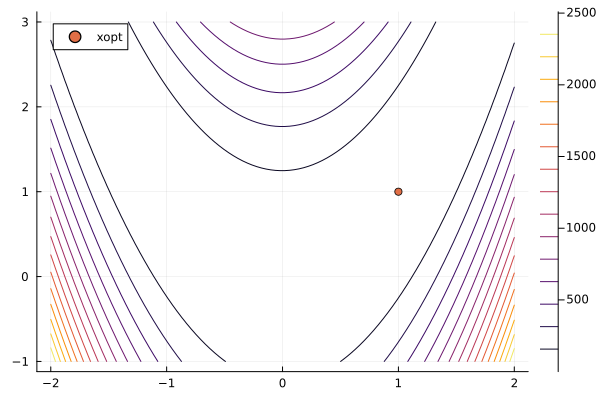

In [41]:
xx = range(-2, 2, length=100)
yy = range(-1, 3, length=100)
plot(xx, yy, (x,y) -> testfn.f([x,y]), st=:contour)
scatter!([testfn.xopt[1]], [testfn.xopt[2]], label="xopt")

### Visualize State of Belief from Surrogate Model

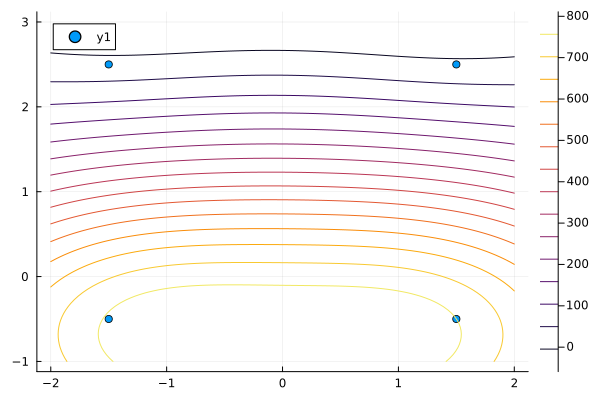

In [42]:
scatter(sur.X[1,:], sur.X[2,:])
plot!(xx, yy, (x,y) -> sur([x,y]).μ, st=:contour, label="μ")

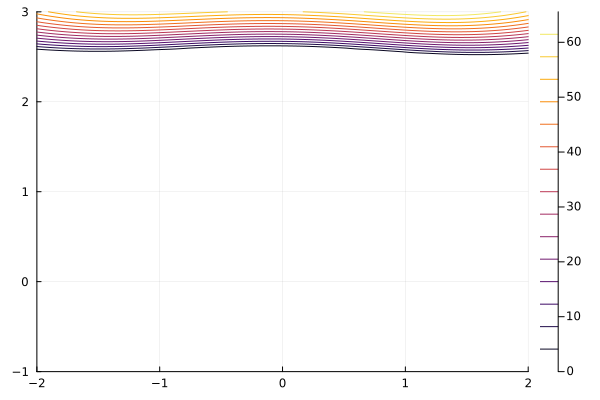

In [43]:
plot(xx, yy, (x,y) -> sur([x,y]).EI, st=:contour)

In [44]:
B = generate_batch(BATCH_SIZE, lbs=lbs, ubs=ubs)
for x0 in eachcol(B)
    x0 = convert(Vector{Float64}, x0)
    
    αxs, ∇αxs = [], []
    # Monte-carlo integrate trajectory for x0
    for sample in 1:MC_SAMPLES
        # Make a copy of our surrogate to pass to the trajectory struct
        # for fantasized computations
        fsur = Base.deepcopy(sur)
        fantasy_ndx = size(fsur.X, 2) + 1

        # Rollout trajectory
        T = Trajectory(fsur, x0, fantasy_ndx; h=HORIZON)
        rollout!(T, lbs, ubs; rnstream=lds_rns[sample,:,:])

        # Evaluate rolled out trajectory
        push!(αxs, α(T))
        push!(∇αxs, first(∇α(T)))
    end # endfor sample
    
    println("$x0 -> $(sum(αxs) / length(αxs))")
end

LoadError: SingularException(2)